# Exercise 5.12: Racetrack (programming) 
Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by $+1$, $-1$, or $0$ in each step, for a total of nine ($3 \times 3$) actions. Both velocity components are restricted to be nonnegative and less than $5$, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are $-1$ for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car's location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability $0.1$ at each time step the velocity increments are both zero, independently of the intended increments. Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

%matplotlib inline
from mpl_toolkits import mplot3d
from itertools import product 

from termcolor import colored

In [71]:
Turn_A_matrix = np.array([
    [0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
]).astype(int)

In [72]:
Turn_B_matrix = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3],     
    [0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],
    [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
]).astype(int)

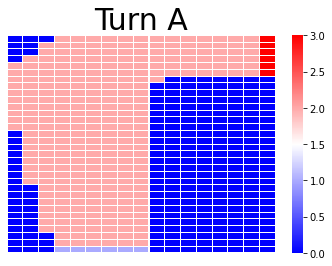

In [73]:
fig = sns.heatmap(Turn_A_matrix, cmap="bwr", annot=False, 
                  linewidth=.01, xticklabels=False, yticklabels=False)
fig.set_title("Turn A", fontsize=30)

#YlGnBu
plt.show()
plt.close()

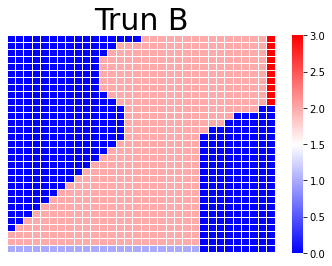

In [74]:
fig = sns.heatmap(Turn_B_matrix, cmap="bwr", annot=False, 
                  linewidth=.01, xticklabels=False, yticklabels=False)
fig.set_title("Trun B", fontsize=30)
plt.show()
plt.close()

In [75]:
def set_start_finish_positions(Matrix):
    A = np.where(Matrix==1)
    B = np.where(Matrix==3)
    start_positions = list(zip(A[0], A[1]))
    finish_positions = list(zip(B[0], B[1]))
    return start_positions, finish_positions

In [76]:
def set_states(Matrix):

    A = np.where(((Matrix == 2) + (Matrix == 1) + (Matrix == 3)) == True)
    states = [(A[0][i], A[1][i], y, x) for i in range(len(A[0])) 
              for y in range(min_vy, max_vy+1) for x in range(min_vx, max_vx+1)]
    return states

In [77]:
def start():
    start_position = start_positions[np.random.choice(len(start_positions))]
    x, y = start_position
    return (x, y, 0, 0)

In [78]:
def possible_actions(state):

    _, _, y, x = state
    
    possible_row_actions = [i for i in [-1, 0, 1] if y+i>=min_vy and y+i<=max_vy]
    possible_column_actions = [i for i in [-1, 0, 1] if i+x>= min_vx and i+x<=max_vx]
    
    Actions = [(i,j) for i in possible_row_actions
              for j in possible_column_actions if y+i !=0 or x+j !=0]
    probabilities = [1/len(Actions) for _ in Actions]
    return [Actions , probabilities]

In [79]:
def is_valid_position(m, n, Matrix):
    if m < 0:
        return False
    if n < 0:
        return False
    
    try:
        if Matrix[m,n] == 0:
            return False
        else: 
            return True
    except:
        return False

In [80]:
def RacetrackEnv(state, action, noise = True):

    # Making the task more challenging!!
    if noise and np.random.uniform() < 0.1:
        return state, -1, False
        
    x, y, a, b = state
    u, v = action 
    if (u>1 or u<-1 or
        v>1 or v<-1 or
        a+u > max_vy or a+u < min_vy or 
        b+v > max_vx or b+v < min_vx or 
        (a+u == 0 and b+v == 0)):
        
        raise Exception("The action %s is not allowed for the state %s" %(action, state))
        
    if is_valid_position(x -(a+u), y+b+v, Turn_Matrix):
        return (x -(a+u), y+b+v, a+u, b+v), -1, False
    elif cross_finish_line(state, action):
        return None, 0, True  
    else:
        return start(), -1, False

In [81]:
def cross_finish_line(state, action):
    x_0, y_0, u, v = state
    a, b = action
    
    x_1, y_1 = x_0-(u+a), y_0+v+b

    m_0, n_0 = finish_positions[0]
    m_1, n_1 = finish_positions[-1]
   
    det = (x_1-x_0)*(n_0-n_1) - (y_1-y_0)*(m_0-m_1)
    if det == 0:
        return False
    t = (1/det) *( (n_0-n_1)*(m_0-x_0) + (m_1-m_0)*(n_0-y_0) )
    s = (1/det) *( (y_0-y_1)*(m_0-x_0) + (x_1-x_0)*(n_0-y_0) )
    
    if 0<=s<=1 and 0<t<1:
        return True
    return False

In [82]:
def BehaiviarPolicy(Matrix): 
    states = set_states(Matrix) 
    behaiviar_policy = {}
    for s in states:
        behaiviar_policy[s] = possible_actions(s) 
    return behaiviar_policy

In [83]:
class Racetrack:

    def __init__(self, n_iters, Matrix, gamma = 1, 
                 eps = 1, Type = "off", ):

        self.Type = Type
        self.behaiviar_policy = BehaiviarPolicy(Matrix)
        self.target_policy = {}
        self.states = set_states(Matrix)
        self.Q = {}
        self.C = {}
        self.state_action_dist = {}
        self.counter = {}
        
        
        for s in self.states:
            self.Q[s] = {}
            self.target_policy[s] = self.behaiviar_policy[s][0][0]
            for a in self.behaiviar_policy[s][0]:              
                self.Q[s][a] = np.random.normal(-10,1)
                self.C[s,a] = 0.0  
                self.counter[s,a] = 0
                
        
        max_count = 0
        MM = 0
        m = 1000
        st = 1
        for x in range(1, n_iters+1):
            
            if x == 1:
                t1 = time.time()
                print(colored('Starting iteration number:', 'blue'), 1)
            elif (x-1)% 10000 == 0:
                print(colored("Average lenth of episodes for iterations in [%s ... %s]:" %(st, x-1), 'red'), MM/(x-st), '\n',
                      colored('epsilon:', 'red'), eps, '\n',
                      colored('done in:', 'red'), time.time()-t1, 
                      colored('seconds', 'red'), '\n')
                
                t1 = time.time()
                
                st = x
                MM = 0
                max_count = 0
            
                print(colored('Starting iteration number:', 'blue'), x)    
                    
            if Type == 'off' and (x == 1001 or (x-1) % 10000 == 0) and x>1:
                print('update_behaiviar_policy')
                self.update_behaiviar_policy(eps)
            

            
            episode, actions, rewards = self.build_episode()
            
            
            MM += len(episode)
                
            
            G = 0
            W = 1
            count = 0
            while len(episode) > 0:
                count += 1
                s = episode.pop()
                a = actions.pop()
                reward = rewards.pop()
                G = gamma * G + reward
                
                
                ################################
                
                if self.Type == "on":
                    
                    self.counter[s,a] += 1
                    self.Q[s][a] = self.Q[s][a] + (1/self.counter[s,a]) * (G - self.Q[s][a])
                    self.update_behaiviar_policy(eps, s)
                
                ################################
                
                elif self.Type == "off":
                
                    self.C[s, a] += W
                    self.Q[s][a] += (W/self.C[s, a])*(G - self.Q[s][a])
                
                    Max = max(self.Q[s].values())
                    possibleactaions = self.behaiviar_policy[s][0]
                    index = np.random.choice([x for x in range(len(possibleactaions))
                                             if self.Q[s][possibleactaions[x]] >= Max - 1e-12 ] )
                    best_action = possibleactaions[index]
                    self.target_policy[s] = best_action
                
                    if a != best_action:
                        if count > max_count:
                            max_count = count
                            print("Max trveresed lenth", max_count)
                        break
                    W /= self.behaiviar_policy[s][1][index]
                    
                    
        print(colored('End!', 'red', 'on_grey')) 
        self.get_target_policy()
        self.plot_target_policy(Matrix)    
        
    def build_episode(self):    
        next_state = start()
        Done = False
        episode = []
        actions = []
        rewards = []
        while not Done:
            episode.append(next_state)
            
            next_action = self.apply_behaiviar_policy(next_state)

            actions.append(next_action)
            next_state, reward, Done = RacetrackEnv(next_state, next_action)
            rewards.append(reward)
        return episode, actions, rewards  
    
    
    def apply_behaiviar_policy(self, state):
        possibleactaions = self.behaiviar_policy[state][0]
        probabilities = self.behaiviar_policy[state][1]
        index = np.random.choice(range(len(possibleactaions)), p = probabilities)
        next_action = possibleactaions[index]
        return next_action
        

    def update_behaiviar_policy(self, eps, state = None):
        
        if state is None:
            States = self.states
        else:
            States = [state]
            
        for s in States:
            Max = max(self.Q[s].values())
            possibleactaions = self.behaiviar_policy[s][0]
            index = np.random.choice([x for x in range(len(possibleactaions))
                                      if self.Q[s][possibleactaions[x]] >= Max -1e-12])
                    
            best_action = possibleactaions[index]
            for idx in range(len(possibleactaions)):
                if best_action == possibleactaions[idx]:
                    self.behaiviar_policy[s][1][idx] = 1 - eps + eps/len(possibleactaions)
                else:
                    self.behaiviar_policy[s][1][idx] = eps/len(possibleactaions)
            
    def bulid_trajectory(self, position):
        trajectory = []
        path = []
        Done = False
        reward = 0
        a,b = position
        state = (a,b,0,0)
        while not Done:
            trajectory.append(position)
            path.append(state)
            
            if self.Type == 'on':
                idx = np.argmax(self.behaiviar_policy[state][1])
                action = self.behaiviar_policy[state][0][idx]
            elif self.Type == 'off':
                action = self.target_policy[state]
                
            state, r, Done = RacetrackEnv(state, action, noise = False)
            
            if state is not None:
                a,b,_,_= state
                position = (a,b)
                reward += r            
        return trajectory, reward, path
    
    
    def get_target_policy(self):
        if self.Type == 'off':
            print('OFF-Policy')
        elif self.Type == 'on':
            for state in self.behaiviar_policy.keys():
                idx = np.argmax(self.behaiviar_policy[state][1])
                action = self.behaiviar_policy[state][0][idx]
                self.target_policy[state] = action


    def plot_target_policy(self, Matrix):
        
        for start_point in start_positions:
            TR = self.bulid_trajectory(start_point)
            fig = sns.heatmap(Matrix, cmap="bwr", annot=False, 
                          linewidth=.01, xticklabels=True, yticklabels=True)
            for point in TR[0]:
                plt.plot(point[1],point[0], '.r')
    
            fig.set_title("Policy; start point: " + str(start_point), fontsize=15)

      #YlGnBu
            plt.show()
            plt.close()
            print("Rewars is:", -len(TR[0]))

## Set setting for Turn A

In [84]:
Turn_Matrix = Turn_A_matrix
start_positions, finish_positions = set_start_finish_positions(Turn_Matrix)

min_vx = -4
max_vx = 4

min_vy = 0
max_vy = 4

## ON-Policy MC

Starting iteration number: 1
Average lenth of episodes for iterations in [1 ... 10000]: 44.0957 
 epsilon: 0.1 
 done in: 31.032618045806885 seconds 

Starting iteration number: 10001
Average lenth of episodes for iterations in [10001 ... 20000]: 28.2014 
 epsilon: 0.1 
 done in: 20.03031063079834 seconds 

Starting iteration number: 20001
Average lenth of episodes for iterations in [20001 ... 30000]: 27.007 
 epsilon: 0.1 
 done in: 19.721027851104736 seconds 

Starting iteration number: 30001
Average lenth of episodes for iterations in [30001 ... 40000]: 26.3378 
 epsilon: 0.1 
 done in: 19.34465217590332 seconds 

Starting iteration number: 40001
Average lenth of episodes for iterations in [40001 ... 50000]: 25.6016 
 epsilon: 0.1 
 done in: 19.57880711555481 seconds 

Starting iteration number: 50001
Average lenth of episodes for iterations in [50001 ... 60000]: 24.8571 
 epsilon: 0.1 
 done in: 17.788896799087524 seconds 

Starting iteration number: 60001
Average lenth of episodes

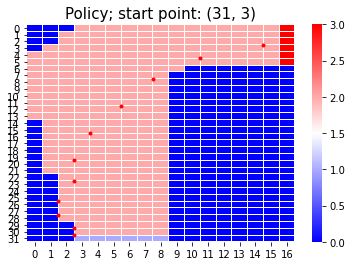

Rewars is: -11


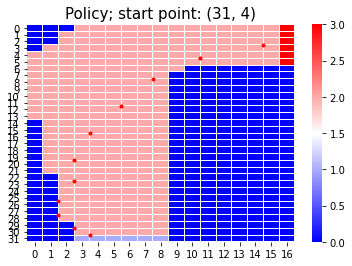

Rewars is: -11


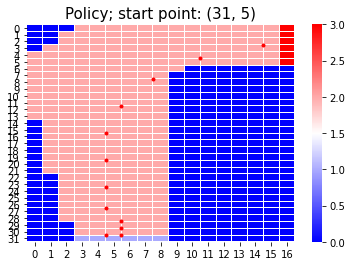

Rewars is: -12


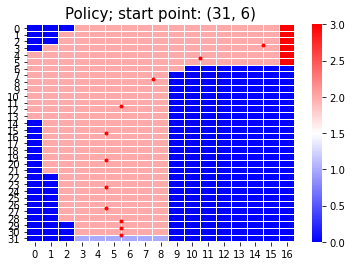

Rewars is: -11


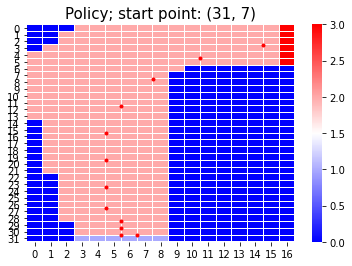

Rewars is: -12


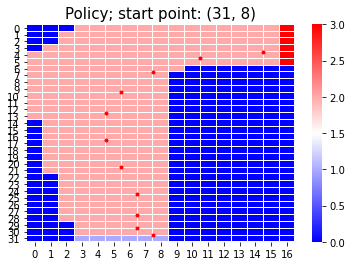

Rewars is: -11


In [85]:
OnPolicyModelA = Racetrack(2000000, Turn_Matrix, gamma = .99,  Type = 'on', eps = .1)

## OFF-Policy MC

Starting iteration number: 1
Max trveresed lenth 11
Max trveresed lenth 12
update_behaiviar_policy
Max trveresed lenth 13
Max trveresed lenth 14
Max trveresed lenth 15
Average lenth of episodes for iterations in [1 ... 10000]: 689.6079 
 epsilon: 0.1 
 done in: 356.1151120662689 seconds 

Starting iteration number: 10001
update_behaiviar_policy
Max trveresed lenth 1
Max trveresed lenth 9
Max trveresed lenth 11
Max trveresed lenth 13
Max trveresed lenth 14
Max trveresed lenth 16
Average lenth of episodes for iterations in [10001 ... 20000]: 29.0707 
 epsilon: 0.1 
 done in: 17.02009081840515 seconds 

Starting iteration number: 20001
update_behaiviar_policy
Max trveresed lenth 10
Max trveresed lenth 11
Max trveresed lenth 12
Max trveresed lenth 13
Max trveresed lenth 14
Average lenth of episodes for iterations in [20001 ... 30000]: 24.8947 
 epsilon: 0.1 
 done in: 13.535102844238281 seconds 

Starting iteration number: 30001
update_behaiviar_policy
Max trveresed lenth 12
Max trveresed 

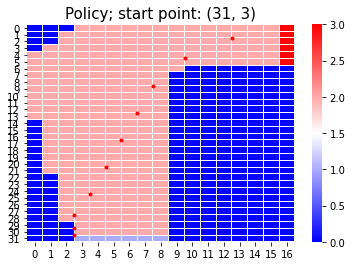

Rewars is: -10


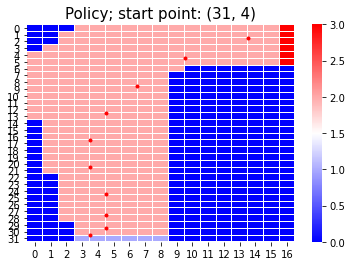

Rewars is: -10


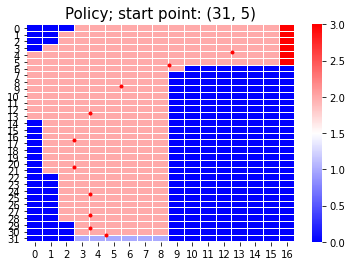

Rewars is: -10


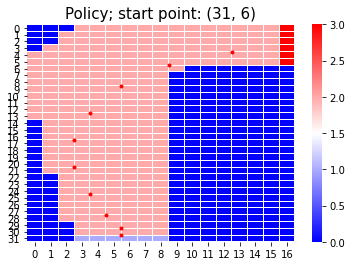

Rewars is: -10


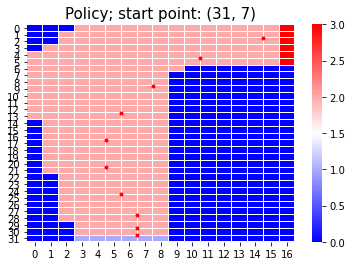

Rewars is: -10


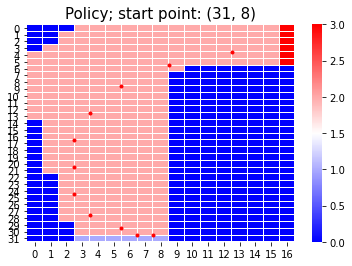

Rewars is: -11


In [86]:
OffPolicyModelB = Racetrack(2000000, Turn_Matrix, gamma = .99, Type = 'off', eps = .1)

## Set setting for Turn B

In [87]:
Turn_Matrix = Turn_B_matrix
start_positions, finish_positions = set_start_finish_positions(Turn_Matrix)

min_vx = -4
max_vx = 4

min_vy = 0
max_vy = 4

## ON-Policy MC

Starting iteration number: 1
Average lenth of episodes for iterations in [1 ... 10000]: 24.4948 
 epsilon: 0.1 
 done in: 17.77644658088684 seconds 

Starting iteration number: 10001
Average lenth of episodes for iterations in [10001 ... 20000]: 17.9209 
 epsilon: 0.1 
 done in: 13.654301881790161 seconds 

Starting iteration number: 20001
Average lenth of episodes for iterations in [20001 ... 30000]: 16.751 
 epsilon: 0.1 
 done in: 12.709665775299072 seconds 

Starting iteration number: 30001
Average lenth of episodes for iterations in [30001 ... 40000]: 15.9387 
 epsilon: 0.1 
 done in: 12.776051044464111 seconds 

Starting iteration number: 40001
Average lenth of episodes for iterations in [40001 ... 50000]: 15.218 
 epsilon: 0.1 
 done in: 12.405118227005005 seconds 

Starting iteration number: 50001
Average lenth of episodes for iterations in [50001 ... 60000]: 14.6465 
 epsilon: 0.1 
 done in: 11.49114727973938 seconds 

Starting iteration number: 60001
Average lenth of episodes

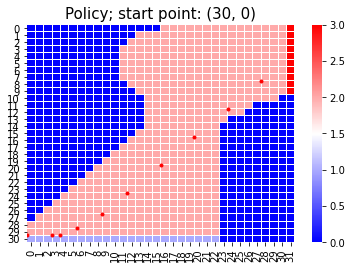

Rewars is: -10


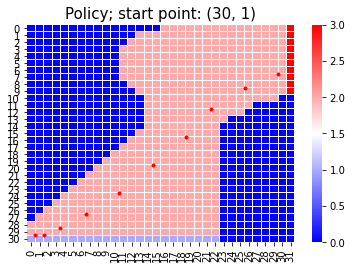

Rewars is: -10


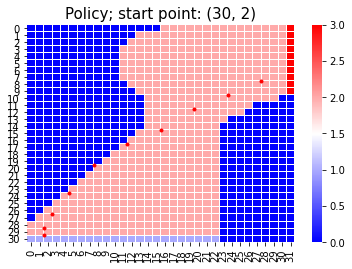

Rewars is: -10


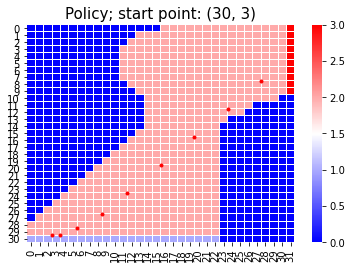

Rewars is: -9


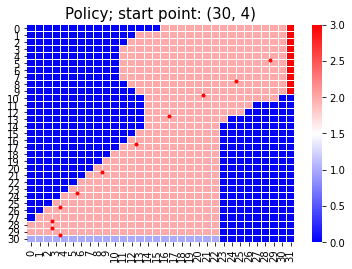

Rewars is: -11


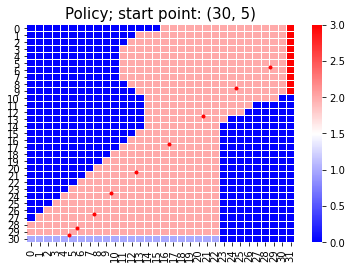

Rewars is: -9


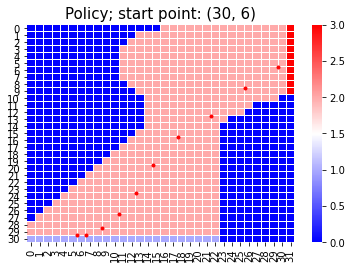

Rewars is: -10


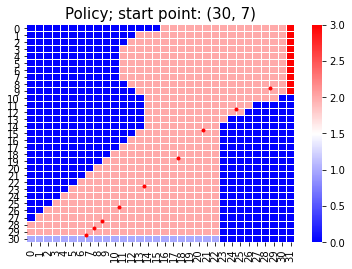

Rewars is: -9


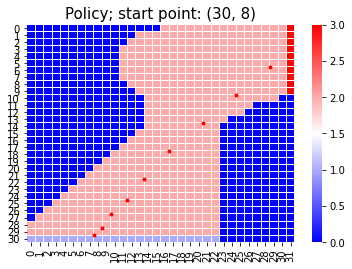

Rewars is: -9


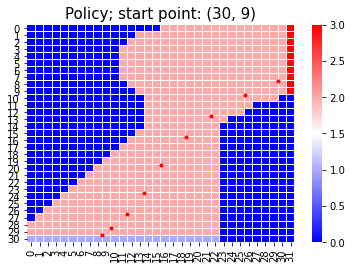

Rewars is: -9


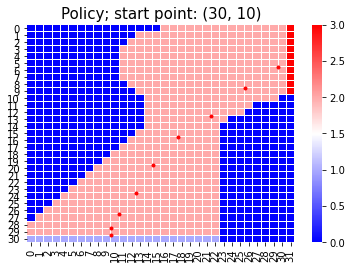

Rewars is: -9


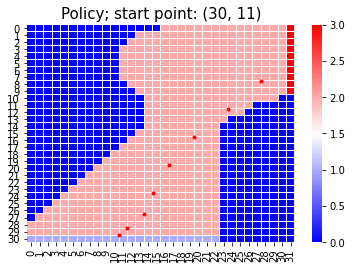

Rewars is: -8


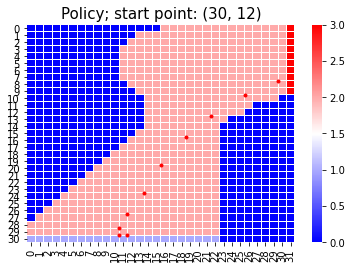

Rewars is: -10


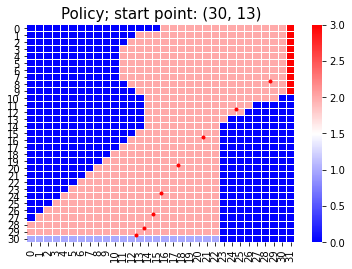

Rewars is: -8


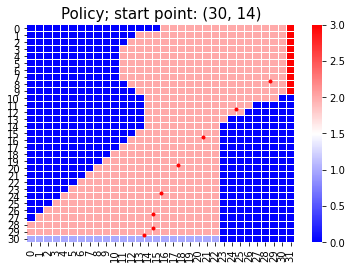

Rewars is: -8


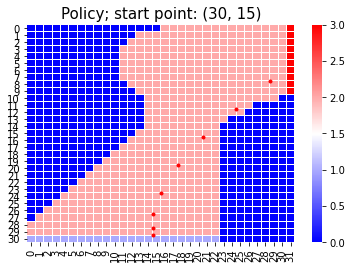

Rewars is: -8


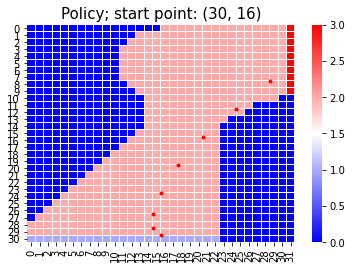

Rewars is: -8


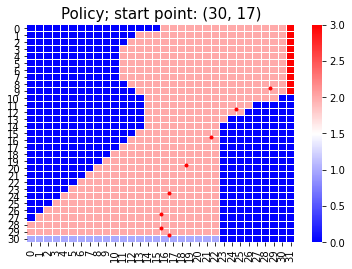

Rewars is: -8


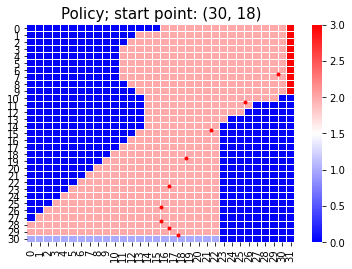

Rewars is: -9


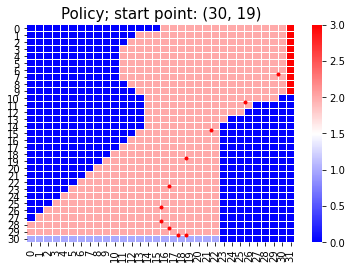

Rewars is: -10


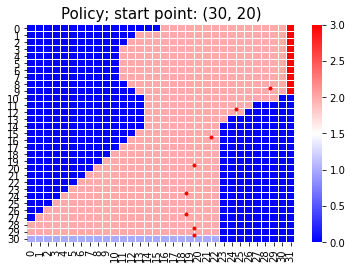

Rewars is: -8


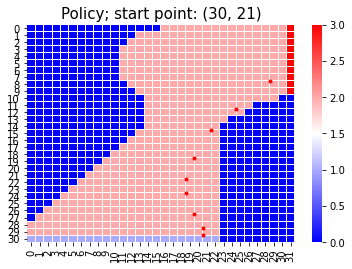

Rewars is: -9


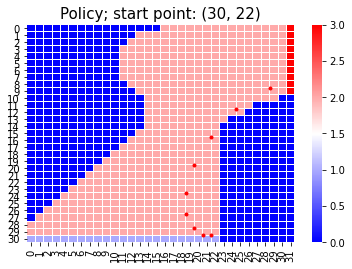

Rewars is: -9


In [88]:
OnPolicyModel = Racetrack(2000000, Turn_Matrix, gamma = .99, Type = 'on', eps = .1)

In [89]:
## OFF-Policy MC

Starting iteration number: 1
Max trveresed lenth 10
Max trveresed lenth 11
Max trveresed lenth 12
update_behaiviar_policy
Max trveresed lenth 14
Average lenth of episodes for iterations in [1 ... 10000]: 71.2579 
 epsilon: 0.1 
 done in: 36.89439392089844 seconds 

Starting iteration number: 10001
update_behaiviar_policy
Max trveresed lenth 2
Max trveresed lenth 3
Max trveresed lenth 6
Max trveresed lenth 12
Max trveresed lenth 14
Max trveresed lenth 15
Average lenth of episodes for iterations in [10001 ... 20000]: 20.7858 
 epsilon: 0.1 
 done in: 12.003211736679077 seconds 

Starting iteration number: 20001
update_behaiviar_policy
Max trveresed lenth 3
Max trveresed lenth 8
Max trveresed lenth 12
Max trveresed lenth 13
Average lenth of episodes for iterations in [20001 ... 30000]: 21.5697 
 epsilon: 0.1 
 done in: 11.766130685806274 seconds 

Starting iteration number: 30001
update_behaiviar_policy
Max trveresed lenth 2
Max trveresed lenth 10
Max trveresed lenth 11
Max trveresed lent

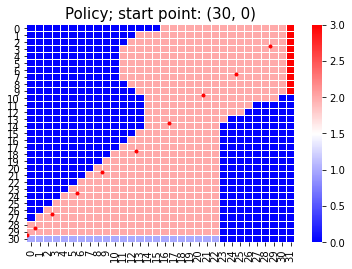

Rewars is: -10


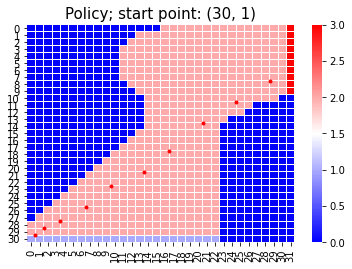

Rewars is: -10


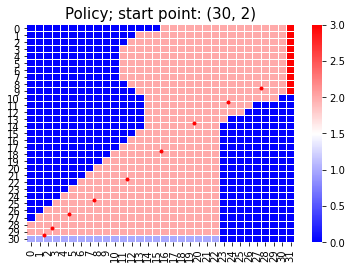

Rewars is: -9


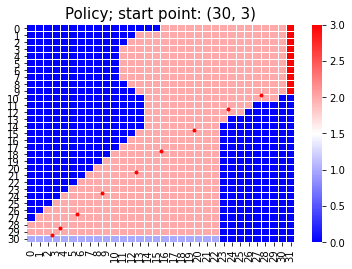

Rewars is: -9


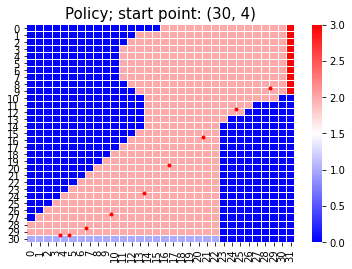

Rewars is: -9


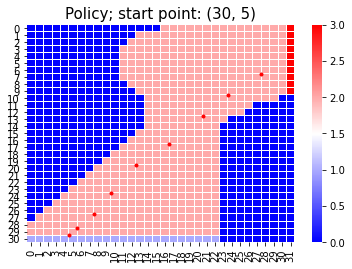

Rewars is: -9


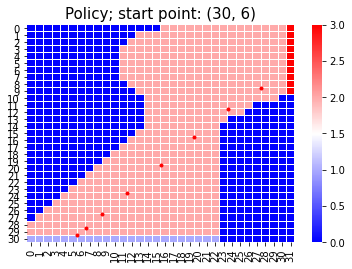

Rewars is: -8


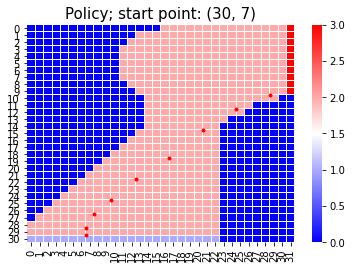

Rewars is: -9


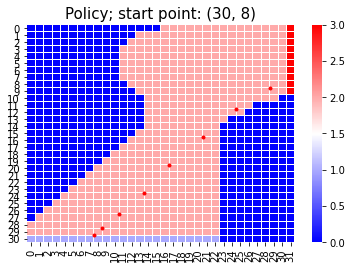

Rewars is: -8


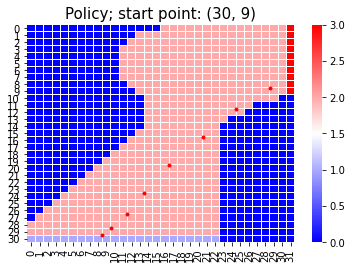

Rewars is: -8


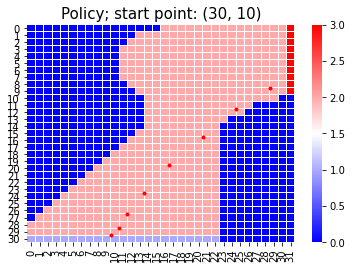

Rewars is: -8


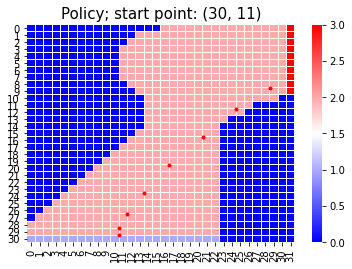

Rewars is: -8


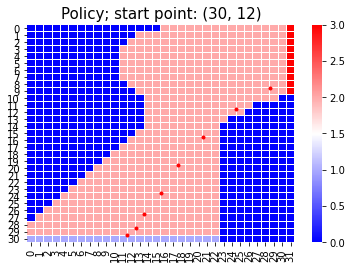

Rewars is: -8


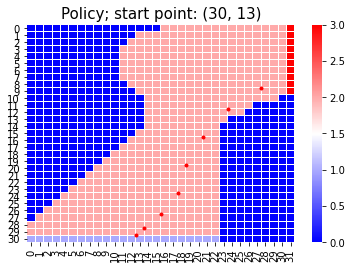

Rewars is: -8


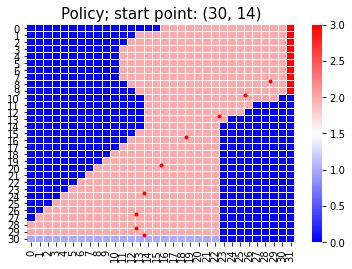

Rewars is: -9


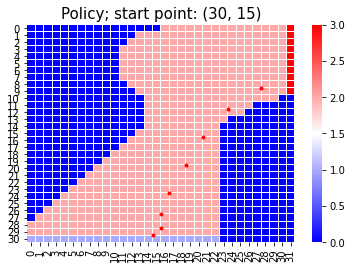

Rewars is: -8


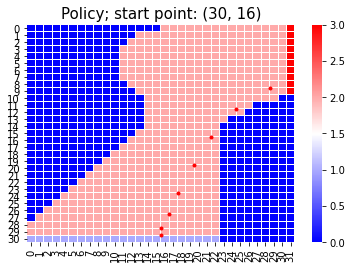

Rewars is: -8


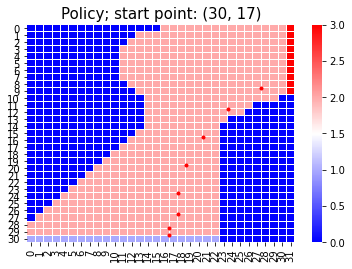

Rewars is: -8


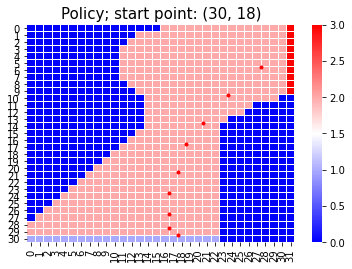

Rewars is: -9


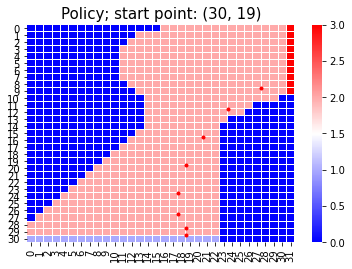

Rewars is: -8


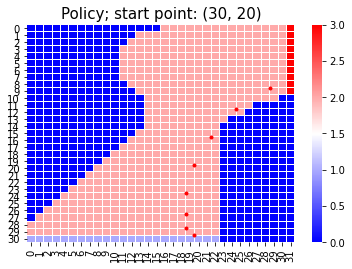

Rewars is: -8


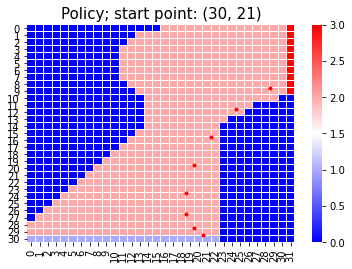

Rewars is: -8


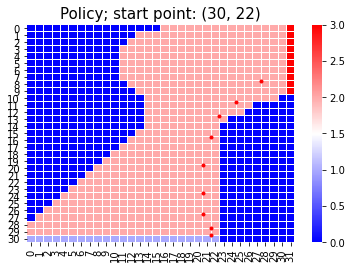

Rewars is: -9


In [90]:
OffPolicyModel = Racetrack(2000000, Turn_Matrix, gamma = .99, Type = 'off', eps = .1)